In [1]:
import nltk
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import bokeh
import matplotlib.pyplot as plt
import pylab as pl
from ast import literal_eval
import string
import random
import cache_magic
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.stem import WordNetLemmatizer

%cache magic is now registered in ipython


In [2]:
import os

In [3]:
DATA_MAG = "/Users/pnguyen/Documents/DaVinci/Data/wine-reviews/winemag-data-130k-v2.csv"

In [4]:
TOKENIZED_DATA_MAG = "/Users/pnguyen/Documents/DaVinci/Data/wine-reviews/winemag-data-130k-v2-tokenized.csv"

In [5]:
df = pd.read_csv(DATA_MAG, index_col=0)

In [6]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
df.rename(columns={'variety': 'varietal'}, inplace=True)
# gotta use the correct terminology
# yes I'm a bit snobbish why'd you ask?
# sorry not sorry

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21beeda0>]],
      dtype=object)

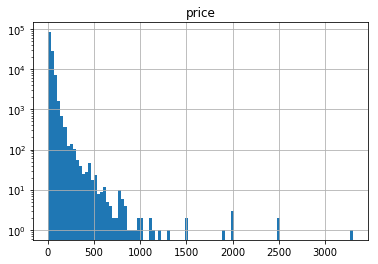

In [8]:
df.hist(column = 'price', bins=100, log=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a228aa828>]],
      dtype=object)

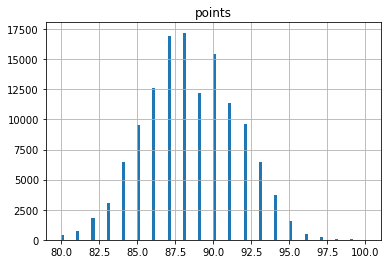

In [9]:
df.hist(column = 'points', bins=100)

In [10]:
df['unique_taster'] = df['taster_name'] + df['taster_twitter_handle'].fillna('__notwitter')

In [11]:
df['unique_taster'].value_counts()

Roger Voss@vossroger                25514
Michael Schachner@wineschach        15134
Kerin O’Keefe@kerinokeefe           10776
Virginie Boone@vboone                9537
Paul Gregutt@paulgwine               9532
Matt Kettmann@mattkettmann           6332
Joe Czerwinski@JoeCz                 5147
Sean P. Sullivan@wawinereport        4966
Anna Lee C. Iijima__notwitter        4415
Jim Gordon@gordone_cellars           4177
Anne Krebiehl MW@AnneInVino          3685
Lauren Buzzeo@laurbuzz               1835
Susan Kostrzewa@suskostrzewa         1085
Mike DeSimone@worldwineguys           514
Jeff Jenssen@worldwineguys            491
Alexander Peartree__notwitter         415
Carrie Dykes__notwitter               139
Fiona Adams@bkfiona                    27
Christina Pickard@winewchristina        6
Name: unique_taster, dtype: int64

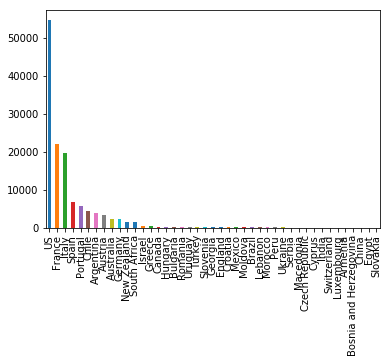

In [12]:
fig, ax = plt.subplots()
df['country'].value_counts().plot(ax=ax, kind='bar')

A few countries makes up for most of the wines

279.48470588235296

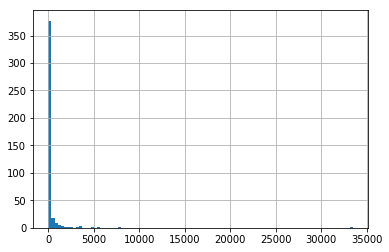

In [13]:
df.groupby(by='province')['title'].nunique().hist(bins=100)
df.groupby(by='province')['title'].nunique().mean() #number of wines per province on average

In [14]:
df['province'].value_counts()[:10]

California          36247
Washington           8639
Bordeaux             5941
Tuscany              5897
Oregon               5373
Burgundy             3980
Northern Spain       3851
Piedmont             3729
Mendoza Province     3264
Veneto               2716
Name: province, dtype: int64

In [15]:
df['varietal'].value_counts()[:20]

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Riesling                     5189
Sauvignon Blanc              4967
Syrah                        4142
Rosé                         3564
Merlot                       3102
Nebbiolo                     2804
Zinfandel                    2714
Sangiovese                   2707
Malbec                       2652
Portuguese Red               2466
White Blend                  2360
Sparkling Blend              2153
Tempranillo                  1810
Rhône-style Red Blend        1471
Pinot Gris                   1455
Name: varietal, dtype: int64

The average (mean) province contributes about 300 wines to the list. But obviously some provinces dominate.

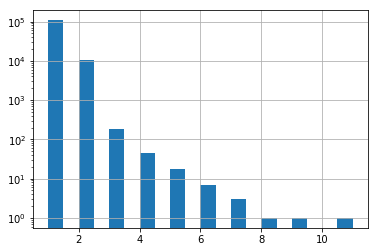

In [16]:
df['title'].value_counts().hist(bins=20, log=True)

Most wines appear only once, but seems like a few appears multiple times

In [17]:
df.groupby(by='country')['designation'].value_counts().nlargest(20)

country    designation    
US         Reserve            1485
           Estate             1210
Italy      Riserva             690
US         Estate Grown        600
Chile      Reserva             520
France     Barrel sample       375
Spain      Crianza             343
US         Dry                 326
France     Vieilles Vignes     301
Spain      Reserva             270
France     Barrel Sample       252
US         Estate Bottled      252
Portugal   Reserva             226
Argentina  Reserva             224
France     Tradition           221
Italy      Brut                186
US         Old Vine            185
Italy      Extra Dry           180
US         Rosé of             169
France     Brut Rosé           165
Name: designation, dtype: int64

In [18]:
top_grape_country = df.groupby(by='country')['varietal'].value_counts().nlargest(100).to_frame('count').reset_index()
top_grape_country

,country,varietal,count
0,US,Pinot Noir,9885
1,US,Cabernet Sauvignon,7315
2,US,Chardonnay,6801
3,France,Bordeaux-style Red Blend,4725
4,Italy,Red Blend,3624
5,US,Syrah,3244
6,US,Red Blend,2972
7,France,Chardonnay,2808
8,Italy,Nebbiolo,2736
9,US,Zinfandel,2711


In [19]:
top_grape = df['varietal'].value_counts().nlargest(50).to_frame('count').reset_index()
top_grape.rename(columns={'index':'varietal'}, inplace=True)
top_grape

,varietal,count
0,Pinot Noir,13272
1,Chardonnay,11753
2,Cabernet Sauvignon,9472
3,Red Blend,8946
4,Bordeaux-style Red Blend,6915
5,Riesling,5189
6,Sauvignon Blanc,4967
7,Syrah,4142
8,Rosé,3564
9,Merlot,3102


In [20]:
for i in range(5):
    print(df['description'][i])
    print('\n')

Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.


This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.


Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.


Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.


Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, i

In [21]:
country_df = df.groupby(by='country').agg({'points':'median','price':'median','description':'; '.join}).reset_index()
varietal_df = df.groupby(by='varietal').agg({'points':'median','price':'median','description':'; '.join}).reset_index()
country_varietal_df = df.groupby(by=['country','varietal']).agg({'points':'median','price':'median','description':'; '.join}).reset_index()

In [22]:
# obtain grape name tokens for later removal from description
grape_names = df['varietal'].fillna('').unique().tolist()
grape_tokens = []
for name in grape_names:
    name = name.lower()
    tokens = re.split('[- ]', name)
    grape_tokens += tokens

In [23]:
wine_remove_words = ['wine','rosé', 'red', 'white', 'drink', 'aroma', 'flavor','vineyard']
other_remove_words = ['\'s', "'"]

In [24]:
post_lem_remove = set(wine_remove_words + other_remove_words)
pre_lem_remove = set([p for p in string.punctuation] + nltk.corpus.stopwords.words('english') + grape_tokens)
#use set to improve performance

def clean_tokenizer(text):
    """Turn long text into lowercase tokens, remove punctuations & stopwords
    e.g: Aromas include tropical fruit, broom, brimstone and dried herb.-->
    ['aromas', 'include', 'tropical', 'fruit', 'broom', 'brimstone',
    'dried', 'herb']"""
    tokens = nltk.tokenize.word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = [lemmatizer.lemmatize(t) for t in tokens if not 
                    ((t in pre_lem_remove) or (lemmatizer.lemmatize(t) in post_lem_remove) or (t.isnumeric()))]
    
    return clean_tokens

tfidf = TfidfVectorizer(lowercase=False, tokenizer=clean_tokenizer, token_pattern=None,
                        stop_words=None, max_df=0.7, min_df=10, ngram_range=(1,3))
# discarding terms that occur > 70% of the time & < 10 times. Using both normal & bigrams

In [25]:
tfidf_matrix = tfidf.fit_transform(varietal_df['description'])

In [26]:
tfidf_matrix.shape

(707, 30046)

In [27]:
def top_tfidf_feats(tfidf_row, features, n_feats=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    top_ids = np.argsort(tfidf_row)[::-1][:n_feats]
    # sort features in row (by tfidf score) -> ascending
    # then reverse to get descending, then slice top n
    
    top_features = [(features[i], tfidf_row[i]) for i in top_ids]
    df = pd.DataFrame(top_features) # return as a Dataframe
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(tfidf_matrix, features, row_id, n_feats=25):
    ''' Top tfidf features in specific document (matrix row)
    Gotta call this instead of top_tf_idf_feats because tfidf
    is sparse matrix -> does not support all matrix operations.
    '''
    # first convert a row to full matrix format
    row = np.squeeze(tfidf_matrix[row_id].toarray())
    
    # return a df
    return top_tfidf_feats(row, features, n_feats)

In [28]:
features = tfidf.get_feature_names()

def look_at(varietal_name, n_feats=10):
    row = varietal_df[varietal_df['varietal']==varietal_name]
    row_id = row.index
    print(top_feats_in_doc(tfidf_matrix, features,row_id, n_feats=n_feats))

def look_at_random(n=10, n_feats=10):
    '''Look at n random wines'''
    row_ids = random.sample(range(1, 100), n)
    for row_id in row_ids:
        print('_'*10)
        print(varietal_df.iloc[row_id]['varietal'])
        print(top_feats_in_doc(tfidf_matrix, features,row_id, n_feats=n_feats))

In [29]:
top_grape = df['varietal'].value_counts().nlargest(57).to_frame('count').reset_index()
top_grape.rename(columns={'index':'varietal'}, inplace=True)
top_grape_names = top_grape['varietal'].tolist()
top_grape_names = [grape for grape in top_grape_names if grape not in 
                   ["Red Blend","White Blend","Sparkling Blend","Portuguese Red","Portuguese White", "Port", "Rosé"]]
print(len(top_grape_names))
for grape in top_grape_names:
    print('_________________')
    print(grape)
    look_at(grape, n_feats=10)

50
_________________
Pinot Noir
      feature     tfidf
0      cherry  0.416530
1   raspberry  0.216684
2      tannin  0.206167
3        cola  0.162965
4     acidity  0.155619
5         oak  0.139596
6   cranberry  0.130709
7  strawberry  0.119437
8        ripe  0.112122
9        show  0.111994
_________________
Chardonnay
     feature     tfidf
0    acidity  0.237656
1        oak  0.214462
2       pear  0.213404
3  pineapple  0.182648
4      lemon  0.174698
5       ripe  0.166855
6      peach  0.155151
7      toast  0.150226
8       rich  0.143838
9      crisp  0.141518
_________________
Cabernet Sauvignon
      feature     tfidf
0      tannin  0.305122
1  blackberry  0.286228
2      cherry  0.266858
3         oak  0.208070
4     currant  0.193269
5      cassis  0.182691
6         cab  0.179862
7   chocolate  0.137085
8        plum  0.117316
9       cedar  0.113323
_________________
Bordeaux-style Red Blend
      feature     tfidf
0      tannin  0.423782
1        ripe  0.191090
2     

     feature     tfidf
0    amarone  0.390461
1     cherry  0.260217
2      spice  0.234247
3    tobacco  0.155571
4       cola  0.141493
5    leather  0.130296
6       dark  0.128604
7      berry  0.123115
8  intensity  0.119921
9      dried  0.117468
_________________
Chenin Blanc
   feature     tfidf
0  acidity  0.276028
1    honey  0.195122
2     pear  0.192216
3     ripe  0.167843
4    crisp  0.142921
5  texture  0.141912
6      dry  0.140053
7    sweet  0.138546
8    peach  0.128518
9   citrus  0.124936
_________________
Tempranillo Blend
      feature     tfidf
0       berry  0.333592
1        plum  0.299913
2       rioja  0.223607
3         oak  0.171212
4      earthy  0.167402
5        feel  0.161465
6      cherry  0.139511
7  blackberry  0.133361
8        note  0.129483
9       baked  0.126491
_________________
Carmenère
      feature     tfidf
0      herbal  0.431034
1       berry  0.308937
2        plum  0.237788
3       olive  0.194347
4        feel  0.180976
5         oak

In [30]:
look_at_random(n=10, n_feats=10)

__________
Assyrtico
          feature     tfidf
0           lemon  0.296453
1          citrus  0.260213
2            fish  0.205149
3        sea salt  0.170090
4            salt  0.153498
5  tropical fruit  0.152732
6            pair  0.152240
7           start  0.144691
8             sea  0.143536
9        tropical  0.139669
__________
Alicante
                  feature     tfidf
0           cooking spice  0.192269
1                 tuscany  0.184412
2                 cooking  0.178991
3              enjoy soon  0.168769
4  straightforward palate  0.155666
5           smooth tannin  0.148029
6                   spice  0.141697
7                   italy  0.129918
8                    soon  0.122130
9         straightforward  0.121070
__________
Cabernet Sauvignon-Sangiovese
               feature     tfidf
0            cranberry  0.221041
1           peppercorn  0.209715
2    palate light body  0.160562
3     fruit intriguing  0.157857
4         offer strong  0.153065
5    nose palate

In [31]:
top_id = varietal_df[varietal_df['varietal'].isin(top_grape_names)].index

In [32]:
len(df.groupby(by='varietal'))

707

In [33]:
len(df[df['varietal'].isin(top_grape_names)])/len(df)

0.7376414738672473

Picking out the top 50 most common grapes combination out of 707 possible values still leaves us with 74% of the bottles.

In [34]:
top_varietals = varietal_df.iloc[top_id]['varietal'].values

In [35]:
top_tfidf_matrix = tfidf_matrix[top_id]

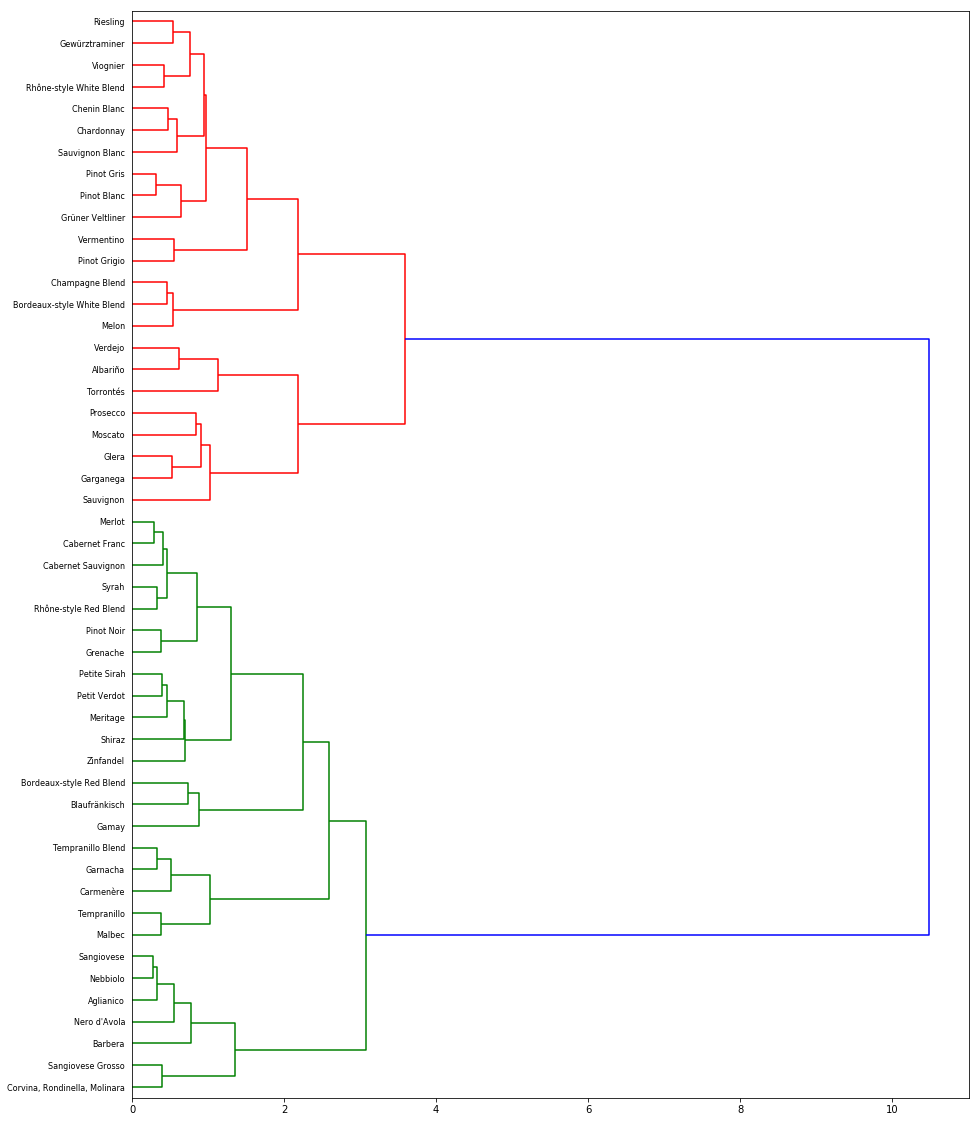

In [36]:
dist = 1 - cosine_similarity(top_tfidf_matrix)
linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right",
                labels=top_varietals)

In [37]:
linkage_matrix.shape

(49, 4)